In [1]:
pip install sqlalchemy

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt
import os

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# Define the path to the SQLite database
db_path = "../Resources/hawaii.sqlite"

In [6]:
# Create an SQLite engine
engine = create_engine(f"sqlite:///{db_path}")

In [7]:
# Read the CSV files into pandas DataFrames
measurements_df = pd.read_csv("hawaii_measurements.csv")
stations_df = pd.read_csv("hawaii_stations.csv")

In [8]:
# Write the DataFrames to the SQLite database, creating tables
measurements_df.to_sql('measurements', con=engine, if_exists='replace', index=False)
stations_df.to_sql('stations', con=engine, if_exists='replace', index=False)

print("Tables created and data imported successfully.")

Tables created and data imported successfully.


In [9]:
# Check if the database file exists
if not os.path.exists(db_path):
    raise FileNotFoundError(f"The database file does not exist at the specified path: {db_path}")


In [10]:
# Declare a Base using automap_base
Base = automap_base()

# Reflect the database tables
Base.prepare(autoload_with=engine)

# Access the reflected classes for the tables
Measurement = Base.classes.measurement
Station = Base.classes.station


In [11]:
# List all the classes that automap found
reflected_classes = Base.classes.keys()
print("Reflected classes in the database:")
for class_name in reflected_classes:
    print(class_name)

Reflected classes in the database:
station
measurement


In [12]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [13]:
# Create a session (link) from Python to the DB
session = Session(engine)

# print a message to confirm the session creation
print("Session created successfully.")

Session created successfully.


# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the Measurement table
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Print the result
print("Most recent date in the dataset:", most_recent_date)

Most recent date in the dataset: 2017-08-23


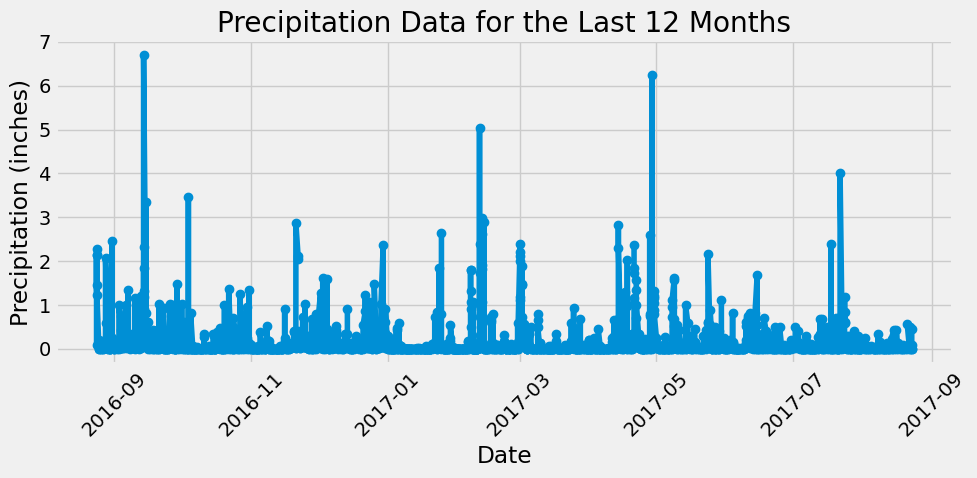

In [15]:
# Find the most recent date in the Measurement table
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Calculate the date one year from the last date in the dataset
most_recent_date = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')  # Adjust format if needed
one_year_later = most_recent_date + dt.timedelta(days=365)

# Perform a query to retrieve the last 12 months of precipitation data
twelve_months_prior = most_recent_date - dt.timedelta(days=365)
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= twelve_months_prior).\
    filter(Measurement.date <= most_recent_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and explicitly set the column names
df = pd.DataFrame(precipitation_data, columns=['date', 'precipitation'])

# Sort the DataFrame by date
df['date'] = pd.to_datetime(df['date'])  # Ensure the date column is in datetime format
df.sort_values('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['precipitation'], marker='o', linestyle='-')
plt.title('Precipitation Data for the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Close the session when done
session.close()

In [16]:
# Step 7: Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['precipitation'].describe()
summary_statistics


count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [17]:
# Step 8: Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

# Print the total number of stations
print("Total number of stations in the dataset:", total_stations)


Total number of stations in the dataset: 9


In [18]:
# Step 9: Design a query to find the most active stations
most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()

# Convert the results to a DataFrame for better readability
active_stations_df = pd.DataFrame(most_active_stations, columns=['Station', 'Count'])

# Print the most active stations
print("Most Active Stations:")
print(active_stations_df)

Most Active Stations:
       Station  Count
0  USC00519281   2772
1  USC00519397   2724
2  USC00513117   2709
3  USC00519523   2669
4  USC00516128   2612
5  USC00514830   2202
6  USC00511918   1979
7  USC00517948   1372
8  USC00518838    511


In [19]:
# Get the most active station id (assuming the first one is the most active)
most_active_station_id = active_stations_df['Station'].iloc[0]

# Perform the query to get the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(
    func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)
).filter(Measurement.station == most_active_station_id).all()

# Print the temperature statistics
print(f"Temperature statistics for station {most_active_station_id}:")
print(f"Lowest Temperature: {temperature_stats[0][0]}")
print(f"Highest Temperature: {temperature_stats[0][1]}")
print(f"Average Temperature: {temperature_stats[0][2]}")


Temperature statistics for station USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


<module 'matplotlib.pyplot' from '/Users/tuckermorris/anaconda3/lib/python3.12/site-packages/matplotlib/pyplot.py'>

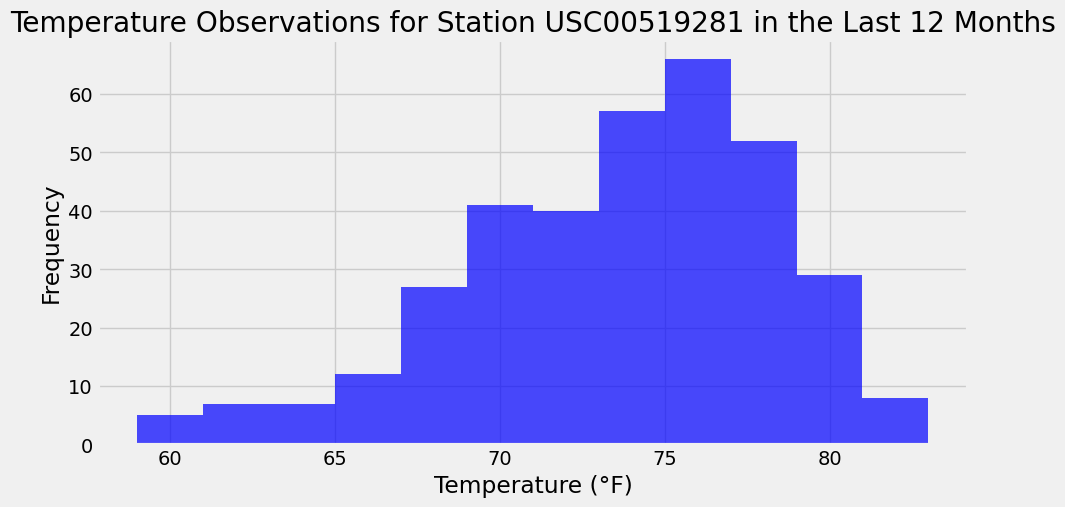

In [20]:
# Step 10: Using the most active station id from the previous query, calculate the lowest, highest, and average temperature
most_active_station_id = active_stations_df['Station'].iloc[0]

# Step 11: Query the last 12 months of temperature observation data for this station
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station_id).\
    filter(Measurement.date >= twelve_months_prior).\
    filter(Measurement.date <= most_recent_date).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and explicitly set the column names
temperature_df = pd.DataFrame(temperature_data, columns=['date', 'temperature'])

# Step 12: Plot the results as a histogram
plt.figure(figsize=(10, 5))
plt.hist(temperature_df['temperature'], bins=12, alpha=0.7, color='blue')
plt.title(f'Temperature Observations for Station {most_active_station_id} in the Last 12 Months')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt

# Close Session

In [21]:
# Close Session
session.close()